In [5]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.exceptions import UndefinedMetricWarning
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)




In [6]:
# Load dataset
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [8]:
df['description_length'] = df['description'].fillna('').apply(len)
df['content_age'] = 2025 - df['release_year']

In [9]:
# Simplify country feature for example (adjust as needed)
df['country'] = df['country'].fillna('Unknown')
df['is_international'] = df['country'].apply(lambda x: 1 if x not in ['United States', 'India'] else 0)

In [10]:
def simplify_rating(r):
    if r in ['TV-Y', 'TV-G', 'TV-Y7']:
        return 'Kids'
    elif r in ['PG', 'PG-13', 'TV-PG', 'TV-14']:
        return 'General'
    elif r in ['TV-MA', 'R']:
        return 'Mature'
    else:
        return 'Other'

In [11]:
df['rating_grouped'] = df['rating'].apply(simplify_rating)
df.dropna(subset=['rating_grouped'], inplace=True)

In [12]:
# Encode target
label_encoder = LabelEncoder()
df['rating_encoded'] = label_encoder.fit_transform(df['rating_grouped'])

In [15]:
# Genre flags
genres = ['Drama', 'Comedy', 'Crime']
for genre in genres:
    df[f'is_{genre}'] = df['listed_in'].apply(lambda x: genre in x if isinstance(x, str) else False)

In [16]:
# Cast feature
df['cast'] = df['cast'].fillna('Unknown')
df['num_cast_members'] = df['cast'].apply(lambda x: len(str(x).split(',')) if str(x) != 'Unknown' else 0)

In [17]:
features = ['description_length', 'num_cast_members'] + [f'is_{g}' for g in genres]
X = df[features]
y = df['rating_encoded']

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [19]:
# SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [20]:
# -------------------------------
# 1️⃣ Logistic Regression
# -------------------------------
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_res, y_train_res)
y_pred_logreg = logreg.predict(X_test)
print("🔹 Logistic Regression")
print(classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_))

explainer_logreg = shap.Explainer(logreg, X_train_res, feature_names=X.columns.tolist())
shap_values_logreg = explainer_logreg(X_train_res)
shap.plots.bar(shap_values_logreg)

C:\Users\MayuriPraveen\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔹 Logistic Regression
              precision    recall  f1-score   support

     General       0.49      0.24      0.32       760
        Kids       0.17      0.78      0.28       172
      Mature       0.65      0.33      0.44       802
       Other       0.01      0.07      0.02        28

    accuracy                           0.33      1762
   macro avg       0.33      0.35      0.26      1762
weighted avg       0.52      0.33      0.36      1762



IndexError: list index out of range

🔹 Random Forest
              precision    recall  f1-score   support

     General       0.46      0.33      0.39       760
        Kids       0.15      0.34      0.21       172
      Mature       0.59      0.35      0.44       802
       Other       0.01      0.14      0.02        28

    accuracy                           0.34      1762
   macro avg       0.30      0.29      0.26      1762
weighted avg       0.48      0.34      0.39      1762



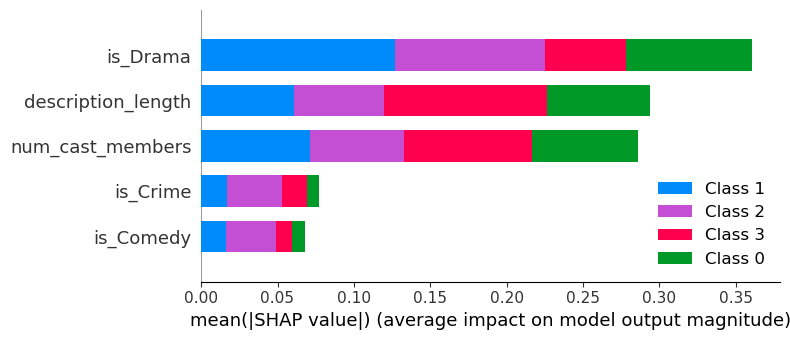

In [21]:
# -------------------------------
# 2️⃣ Random Forest
# -------------------------------
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("🔹 Random Forest")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")



In [152]:
# -------------------------------
# 3️⃣ Gradient Boosting
# -------------------------------
gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=4, random_state=42)
gb.fit(X_train_res, y_train_res)
y_pred_gb = gb.predict(X_test)

print("🔹 Gradient Boosting")
print(classification_report(y_test, y_pred_gb, target_names=label_encoder.classes_))



Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        16
           3       0.30      0.05      0.09        57
           4       0.10      0.02      0.03        98
           5       0.23      0.11      0.15       160
           6       0.33      0.28      0.30       432
           7       0.00      0.00      0.00        44
           8       0.44      0.86      0.59       641
           9       0.17      0.01      0.02       173
          10       0.44      0.11      0.18        61
          11       0.38      0.09      0.14        67
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.40      1760
   macro avg       0.17      0.11      0.11      1760
weighted avg       0.32      0.40      0.32      1760



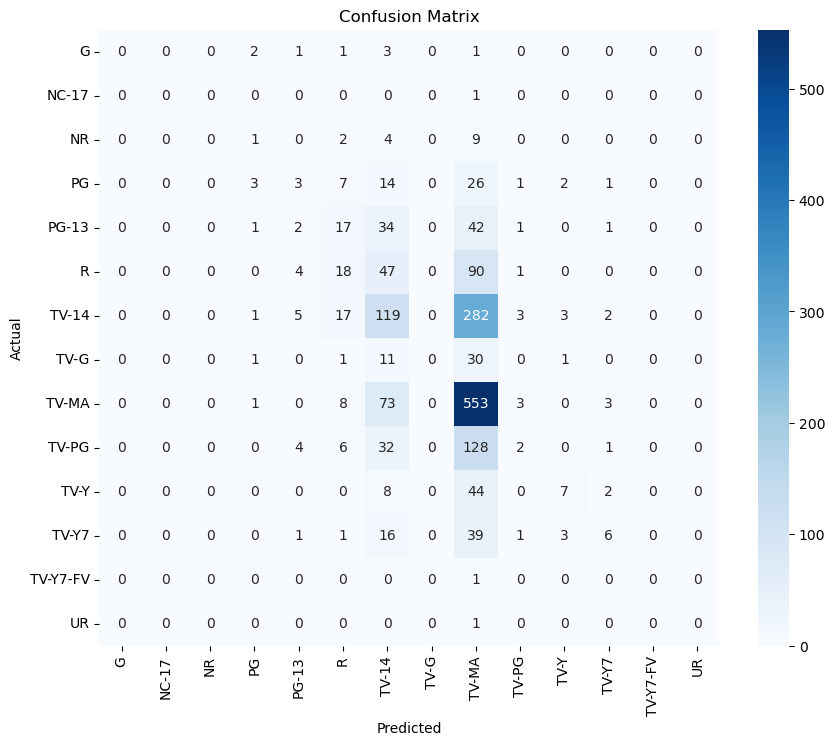

In [153]:
# Optional: Confusion matrix heatmap
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [154]:
print(df.columns.tolist())

['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating_new', 'duration', 'listed_in', 'description', 'description_length', 'content_age', 'is_international', 'rating']


Macro-averaged precision: 0.30377192641993905
              precision    recall  f1-score   support

     General       0.46      0.33      0.39       760
        Kids       0.15      0.34      0.21       172
      Mature       0.59      0.35      0.44       802
       Other       0.01      0.14      0.02        28

    accuracy                           0.34      1762
   macro avg       0.30      0.29      0.26      1762
weighted avg       0.48      0.34      0.39      1762



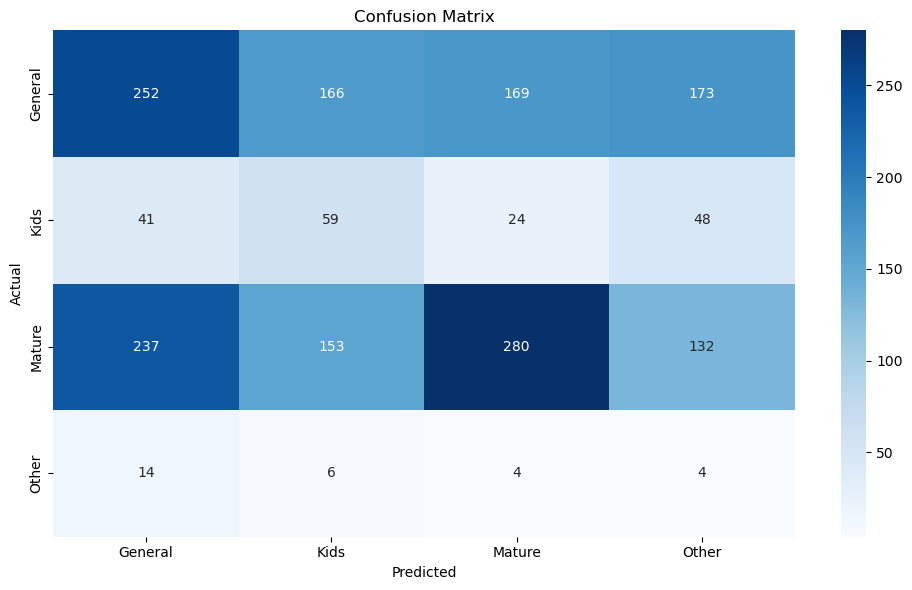

In [155]:
# Filter out rare classes
class_counts = df['rating'].value_counts()
df = df[df['rating'].isin(class_counts[class_counts > 1].index)]
df['rating'] = df['rating'].apply(lambda x: x if class_counts[x] > 1 else 'Other')

# Genre flags
genres = ['Drama', 'Comedy', 'Crime']
for genre in genres:
    df[f'is_{genre}'] = df['listed_in'].apply(lambda x: genre in x if isinstance(x, str) else False)

# Drop missing target labels
df.dropna(subset=['rating'], inplace=True)


rare_ratings = ['G', 'NC-17', 'NR', 'TV-Y7-FV', 'UR']
df['rating_grouped'] = df['rating'].apply(lambda x: 'Other' if x in rare_ratings else x)


# Encode target variable
label_encoder = LabelEncoder()
df['rating_encoded'] = label_encoder.fit_transform(df['rating_grouped'])

df['cast'] = df['cast'].fillna('Unknown')
df['num_cast_members'] = df['cast'].apply(lambda x: len(str(x).split(',')) if str(x) != 'Unknown' else 0)


# Define features and target
features = ['description_length', 'num_cast_members'] + [f'is_{g}' for g in genres]
X = df[features]
y = df['rating_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = rf.predict(X_test)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    print("Macro-averaged precision:", precision)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [156]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    n_estimators=150,        # number of boosting stages
    learning_rate=0.1,       # shrinkage factor applied to weights
    max_depth=4,             # controls overfitting
    random_state=42
)

model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)



# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.29      0.36       760
           1       0.17      0.52      0.25       172
           2       0.64      0.33      0.44       802
           3       0.01      0.14      0.02        28

    accuracy                           0.33      1762
   macro avg       0.32      0.32      0.27      1762
weighted avg       0.51      0.33      0.38      1762



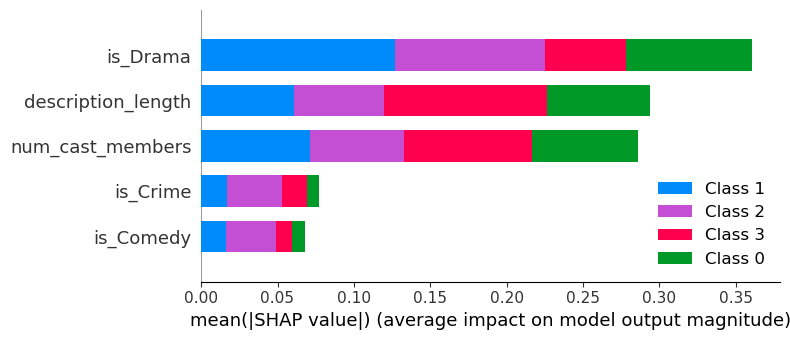

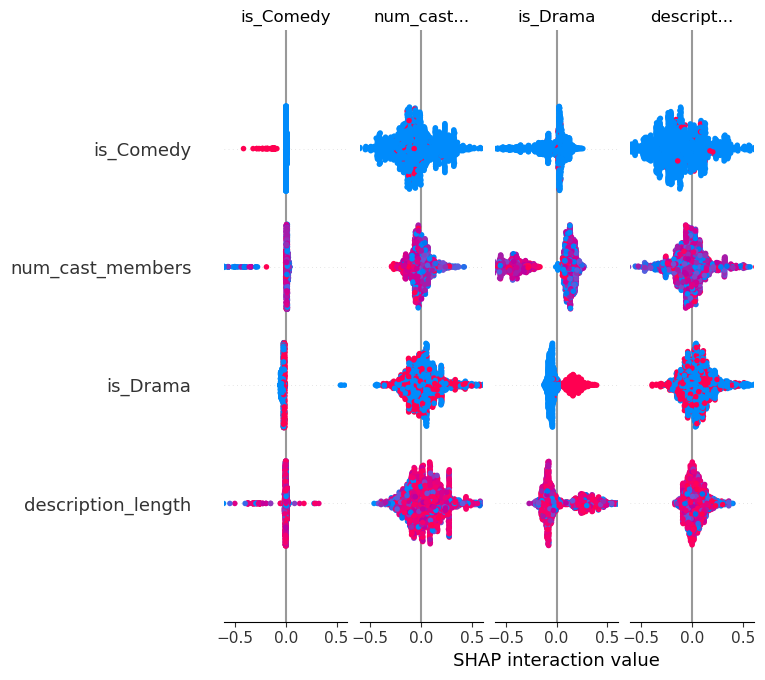

In [160]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Global summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Beeswarm plot for more detail
shap.summary_plot(shap_values, X_test)

In [171]:
print(len(feature_names))
print(shap_values.data.shape)

104
(1760, 104)


In [179]:
type_feature_names = ohe.get_feature_names_out(['type']).tolist()
num_feature_names = ['content_age', 'description_length', 'is_international']
tfidf_feature_names = tfidf.get_feature_names_out().tolist()
feature_names = type_feature_names + num_feature_names + tfidf_feature_names
shap_values.feature_names = feature_names

shap_values.feature_names = feature_names
print(len(feature_names))
print(shap_values.data.shape)
explainer = shap.Explainer(logreg, X_train_combined, feature_names=feature_names)
shap_values = explainer(X_train_combined)
shap.plots.bar(shap_values, clustering=None)

(7040, 104)


AttributeError: 'csr_matrix' object has no attribute 'columns'

In [162]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Beeswarm plot for more detail
shap.summary_plot(shap_values, X_test)

InvalidModelError: GradientBoostingClassifier is only supported for binary classification right now!